In [1]:
## Preliminaries

using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using AdvancedHMC
using ArviZ
using BumpCosmologyGWTC3
using CairoMakie
using Colors
using Cosmology
using DataFrames
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using InferenceObjects
using Interpolations
using JSON
using LaTeXStrings
using MCMCChainsStorage
using NCDatasets
using PairPlots
using PolyLog
using PopModels
using Printf
using ProgressLogging
using Random
using StatsBase
using SpecialFunctions
using StatsFuns
using Trapz
using Turing
using Unitful
using UnitfulAstro
using UnitfulChainRules

include("plots.jl")

  Activating project at `~/35Msun_GWTC3/m1m2_cut`


h_plot (generic function with 1 method)

# Load GWTC-3 Parameter Estimation and Selection Samples

In [2]:
## Samples and Selection

## Set up paths
struct Paths
    gwtc_2_dir::String
    gwtc_3_dir::String
    evt_table_file::String
    o1o2o3_sensitivity_file::String
end

paths = Paths(
    "/mnt/home/ccalvk/ceph/GWTC-2.1", 
    "/mnt/home/ccalvk/ceph/GWTC-3", 
    "/mnt/home/ccalvk/ceph/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json",
    "/mnt/home/ccalvk/ceph/sensitivity-estimates/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5"
)

## Output Directory for Plots and Astro Comparison Plot
outdir = "/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/"
savepath = "../data/Astro_Compare_Feature_m1m2.h5" #first run m1_marginal to write h5py file, for rest, it will append

## Plot Specifications
xlabelsize = 30
ylabelsize = 30
xticklabelsize = 23
yticklabelsize = 23
titlesize = 35
draws = 500

plot_save = true

true

In [3]:
## Load PE
all_pe = load_pe(; gwtc_2_dir=paths.gwtc_2_dir, gwtc_3_dir=paths.gwtc_3_dir)
evt_table = load_event_table(paths.evt_table_file)
all_pe = join_pe_evt_tables(all_pe, evt_table)

┌ Info: Could not read IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5
└ @ BumpCosmologyGWTC3 /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/src/load.jl:26


Row,spin_2y,dec,chirp_mass,redshift,theta_jn,ra,a_1,chi_p_2spin,viewing_angle,mass_1_source,cos_tilt_2,spin_2x,mass_2,cos_iota,chi_eff,mass_2_source,psi_J,log_likelihood,symmetric_mass_ratio,phi_12,spin_2z,phase,a_2,beta,spin_1z,chirp_mass_source,mass_ratio,comoving_distance,total_mass,mass_1,total_mass_source,chi_p,tilt_1,phi_1,tilt_2,cos_tilt_1,iota,luminosity_distance,phi_2,cos_theta_jn,inverted_mass_ratio,spin_1y,phi_jl,psi,spin_1x,gwname,commonName,far
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,SubStrin…,SubStrin…,Float64
1,0.0157482,-1.2029,30.9684,0.0968552,2.77079,1.28323,0.00150978,0.0142601,0.370807,37.7342,0.827167,0.000942395,30.7108,-0.931191,0.00928814,27.999,2.70339,320.05,0.244516,2.46959,0.0232219,3.78693,0.028074,0.00264939,-0.0010508,28.2338,0.742006,418.022,72.0998,41.3889,65.7332,0.0112211,2.3406,5.32462,0.596749,-0.695997,2.76846,458.427,1.51103,-0.932035,1.3477,-0.000887186,2.07373,1.12909,0.000623018,GW150914_095045,GW150914,1.0e-7
2,0.306186,-1.17447,31.6976,0.0858721,2.58701,1.12687,0.927965,0.804829,0.554584,36.8689,-0.708659,-0.277814,33.1735,-0.876785,0.0308062,30.5501,3.19656,324.407,0.247804,0.924199,-0.415259,1.61676,0.585979,0.294629,0.400422,29.1909,0.828614,371.601,73.2084,40.0349,67.419,0.837126,1.12463,1.38345,2.35839,0.431506,2.63993,403.445,2.30765,-0.850119,1.20683,0.822478,5.85641,2.20776,0.155915,GW150914_095045,GW150914,1.0e-7
3,-0.281979,-1.20404,29.1559,0.0984072,2.65664,2.28386,0.377052,0.480531,0.48495,33.7307,0.069959,0.336426,30.3349,-0.864843,-0.164482,27.6172,1.85062,324.894,0.247517,5.15309,0.0307853,3.82701,0.440048,0.136484,-0.324358,26.5438,0.818754,424.561,67.3849,37.05,61.3479,0.349319,2.60655,0.43251,1.50078,-0.860247,2.61563,466.256,5.5856,-0.884698,1.22137,0.0805821,0.184376,0.549502,0.174548,GW150914_095045,GW150914,1.0e-7
4,-0.0257892,-1.28148,29.4337,0.0788087,2.46328,1.66579,0.436312,0.678088,0.678313,31.681,-0.548917,-0.578377,33.4479,-0.670639,-0.148147,31.0044,2.87312,325.099,0.249971,0.599913,-0.380195,0.994084,0.692628,0.250073,0.0789466,27.2835,0.978645,341.613,67.6256,34.1777,62.6854,0.564844,1.38885,2.58624,2.15186,0.180941,2.30587,368.478,3.18615,-0.778632,1.02182,0.226246,0.569816,1.58707,-0.364621,GW150914_095045,GW150914,1.0e-7
5,-0.615255,-1.22545,28.3426,0.093687,2.78603,2.18355,0.53497,0.32345,0.355559,35.457,-0.27069,-0.298152,27.4948,-0.906833,-0.213818,25.1395,4.77553,322.9,0.242752,2.08325,-0.192245,2.68165,0.710205,0.16795,-0.229113,25.9147,0.709015,404.658,66.2736,38.7788,60.5965,0.483425,2.01338,2.17789,1.84491,-0.428273,2.7065,442.491,4.26114,-0.937452,1.41041,0.397043,2.83741,2.81668,-0.275784,GW150914_095045,GW150914,1.0e-7
6,0.0101604,-1.2815,30.2896,0.105684,2.71688,1.89592,0.482283,0.45148,0.424714,33.7674,0.803428,-0.00136464,32.456,-0.945471,-0.0667451,29.3538,2.48545,323.721,0.248778,3.39295,0.0138334,4.20109,0.017218,0.134265,-0.136791,27.3944,0.869293,455.154,69.7921,37.3361,63.1212,0.462477,1.85838,4.59454,0.637765,-0.283633,2.80984,503.16,1.70431,-0.911157,1.15036,-0.459269,5.40313,1.17959,-0.0543767,GW150914_095045,GW150914,1.0e-7
7,-0.0143139,-1.22618,30.8565,0.120825,2.83255,2.33255,0.118997,0.0917852,0.309042,34.8008,0.970927,0.000399219,32.2669,-0.948892,-0.0101696,28.7885,3.17053,319.882,0.247765,4.02482,0.0580812,5.17008,0.0598203,0.0282465,-0.0666291,27.5301,0.827237,518.446,71.2725,39.0056,63.5893,0.0985938,2.16509,0.715448,0.241722,-0.559925,2.8205,580.964,4.74027,-0.952625,1.20884,0.0646731,2.74057,1.51725,0.0744185,GW150914_095045,GW150914,1.0e-7
8,-0.00522301,-1.25144,29.8868,0.118836,3.04766,2.17208,0.171419,0.835042,0.0939295,32.0239,-0.372615,0.805206,32.907,-0.983395,-0.122761,29.4119,0.71106,325.143,

Select PE Samples such that:
$$
\mathrm{PE~Pos}(m_1>20, m_2=[3,50])>0.5
$$

In [4]:
groups = groupby(far_cut(mass_cut(all_pe, thresh=0.5)), :gwname)
gw_names = [group.gwname[1] for group in groups]

open("../data/analyzed_gw_event_names.txt", "w") do io
    for name in gw_names
        println(io, name)
    end
end

println(gw_names)
println(length(gw_names))

SubString{String}["GW150914_095045", "GW151012_095443", "GW170104_101158", "GW170729_185629", "GW170809_082821", "GW170814_103043", "GW170818_022509", "GW170823_131358", "GW190408_181802", "GW190412_053044", "GW190413_052954", "GW190413_134308", "GW190421_213856", "GW190503_185404", "GW190512_180714", "GW190513_205428", "GW190517_055101", "GW190519_153544", "GW190521_074359", "GW190527_092055", "GW190602_175927", "GW190620_030421", "GW190630_185205", "GW190701_203306", "GW190706_222641", "GW190719_215514", "GW190727_060333", "GW190731_140936", "GW190803_022701", "GW190805_211137", "GW190828_063405", "GW190828_065509", "GW190910_112807", "GW190915_235702", "GW190925_232845", "GW190929_012149", "GW191109_010717", "GW191127_050227", "GW191215_223052", "GW191222_033537", "GW191230_180458", "GW200112_155838", "GW200128_022011", "GW200129_065458", "GW200208_130117", "GW200209_085452", "GW200216_220804", "GW200219_094415", "GW200224_222234", "GW200302_015811", "GW200311_115853"]
51


# Plot PE Samples
## $m_1-m_2$ Plane

In [5]:
function frac_mass_bounds(df, m1_min, m2_min, m2_max)
    m1s = df[!, :mass_1_source]
    m2s = df[!, :mass_2_source]
    p_in = sum((m1s .> m1_min) .&& (m2s .> m2_min) .&& (m2s .< m2_max)) / length(m1s)
    p_in
end

function m1m2_kde_plot(df;
    m1_min = 20.0,
    m2_min = 3.0,
    m2_max = 50.0,
    include_legend=false,
    p_cut=[0.9, 0.5, 0.1],
    p_cut_eventlist=0.0,
    rng=Random.default_rng(),
    far_thresh=1,
    alpha_factor=0.5,
    level=0.1,
    draw_cut_lines=false
)
    if p_cut != p_cut_eventlist
        @info("Events will be plotted with p > $(p_cut_eventlist), but reduced by alpha*=$(alpha_factor) at thresholds p < $(p_cut)")
    end

    evt_groups = DataFrames.groupby(df, :gwname)

    evt_groups = [
        evt for evt in evt_groups
        if frac_mass_bounds(evt, m1_min, m2_min, m2_max) >= p_cut_eventlist &&
           evt[1, :far] < far_thresh
    ]

    cs = categorical_palette(length(evt_groups))

    mlow = 0.0
    mhigh = 100.0

    f = Figure(size=(600, 400))
    a = Axis(f[1, 1];
        xlabel=L"m_1~\mathrm{(in~} \mathrm{M}_\odot)",
        ylabel=L"m_2~\mathrm{(in~} \mathrm{M}_\odot)",
        xlabelsize = 28,
        ylabelsize = 28,
        xticklabelsize = 19,
        yticklabelsize = 19,
        limits=(mlow,mhigh,mlow,mhigh),
        xminorgridvisible=true, xminorticksvisible=true,
        yminorgridvisible=true, yminorticksvisible=true
    )

    # Exclusion regions (shaded)
    if draw_cut_lines
        m1_min = 20.0
        m2_min = 3.0
        m2_max = 50.0

        # Left of m1=20
        poly!(a, [0.0, m1_min, m1_min], [0.0, 0.0, m1_min], color=(:grey, 0.25))
        # Below m2=3
        poly!(a, [m1_min, m1_min, 100.0, 100.0], [0.0, m2_min , m2_min, 0.0], color=(:grey, 0.25))
        # Above m2=50
        poly!(a, [m2_max, 100.0, 100.0], [m2_max, 100.0, m2_max], color=(:grey, 0.25))
    end

    # m1 < m2 region
    band!(a, [mlow, mhigh], [mlow, mhigh], [mhigh, mhigh], color=(:grey, 0.25))

    @progress for (i, evt) in enumerate(evt_groups)
        alpha = 1.0
        p = frac_mass_bounds(evt, m1_min, m2_min, m2_max)
        for pc in p_cut
            if p > pc
                break
            else
                alpha *= alpha_factor
            end
        end

        c = (cs[i], alpha)
        npe = size(evt, 1)
        ndraw = min(256, npe)
        draw_inds = randperm(rng, npe)[1:ndraw]

        evt_draw = evt[draw_inds, :]

        x = evt_draw[!, :mass_1_source]
        y = evt_draw[!, :mass_2_source]
        kde_pts = vcat(x', y')
        k = KDE(kde_pts)
        p_kde_pts = [pdf(k, [kde_pts[1,i], kde_pts[2,i]]) + pdf(k, [kde_pts[2,i], kde_pts[1,i]]) for i in axes(kde_pts, 2)]

        p = quantile(p_kde_pts, level)

        dx = maximum(x) - minimum(x)
        xgrid = range(minimum(x)-0.1*dx, maximum(x)+0.1*dx, length=128)

        dy = maximum(y) - minimum(y)
        ygrid = range(minimum(y)-0.1*dy, maximum(y)+0.1*dy, length=129)

        zgrid = [(x ≥ y ? pdf(k, [x, y]) + pdf(k, [y, x]) : zero(x)) for x in xgrid, y in ygrid]

        contour!(a, xgrid, ygrid, zgrid; levels=[p], color=c)
    end

    if include_legend
        Legend(f[2,1],
            [LineElement(color=cs[i], linestyle=nothing) for i in 1:length(evt_groups)],
            [evt[1, :gwname] for evt in evt_groups],
            nbanks=3)
    end

    text!(a, L"\mathrm{P}_\mathrm{PE}~(m_1>20\mathrm{M}_{\odot},~3\mathrm{M}_{\odot}<m_2<50\mathrm{M}_{\odot})>0.5",
    position = (2.5, 80), align = (:left, :bottom), fontsize = 21, color = :black)

    return f
end

m1m2_kde_plot (generic function with 1 method)

┌ Info: Events will be plotted with p > 0.0, but reduced by alpha*=0.5 at thresholds p < 0.5
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sdnNjb2RlLXJlbW90ZQ==.jl:22


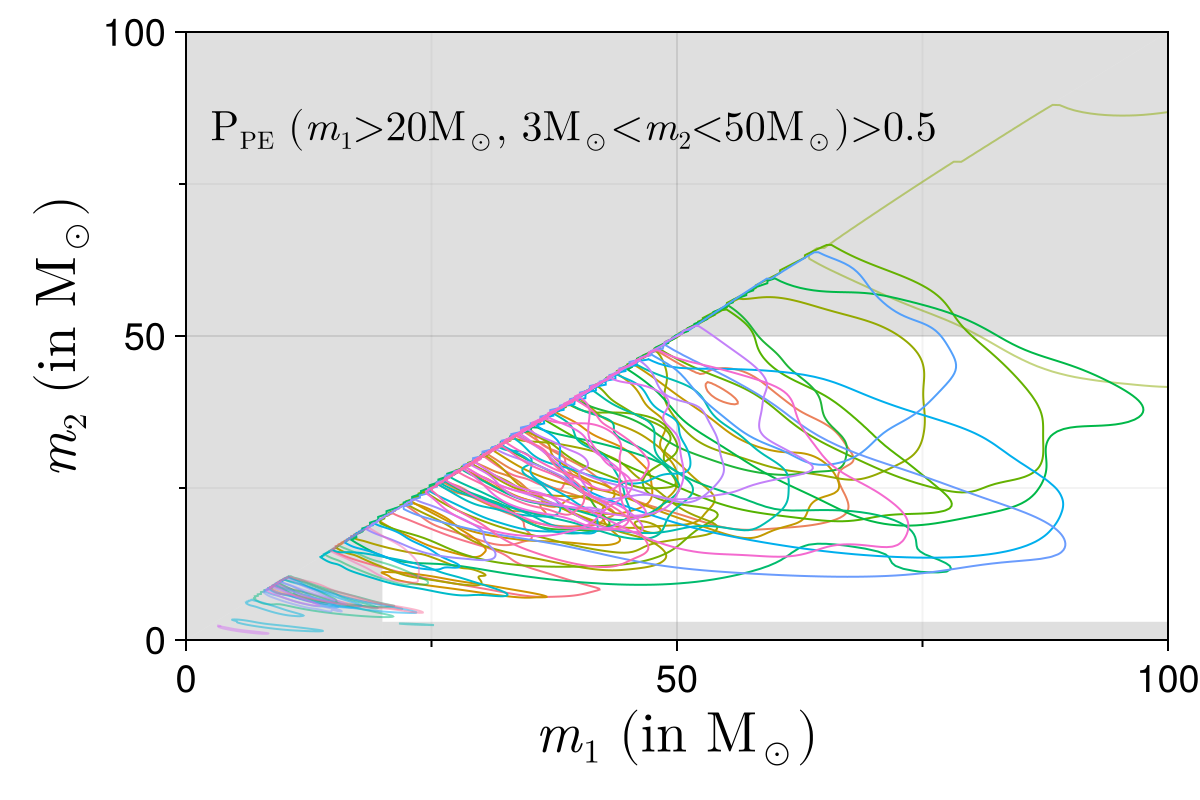

In [6]:
f = m1m2_kde_plot(all_pe; p_cut=0.5, p_cut_eventlist=0.0, draw_cut_lines=true)
if plot_save
    resize_to_layout!(f)  # adjusts the figure size to content
    save(outdir * "m1_m2_kde.pdf", f, px_per_unit = 3)
end
f

## $q-\chi_{\mathrm{eff}}$ Plane

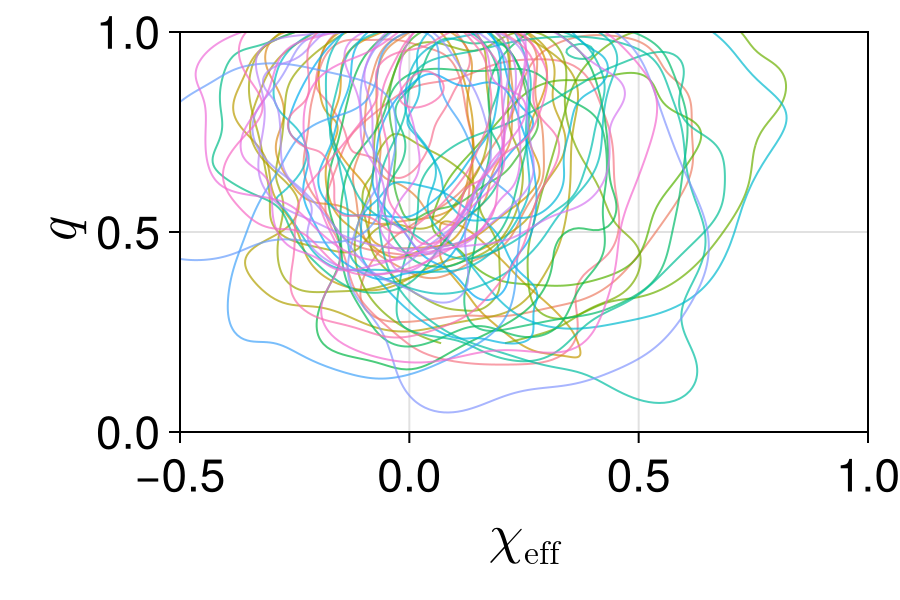

In [7]:
# Random seed for reproducibility
rng = Random.Xoshiro(0xaf91589a0f32ada4)

# Grouped data
pe_grouped = groups  # <-- make sure this exists already
cs = categorical_palette(length(pe_grouped))

# Create figure and axis
f = Figure(size=(450, 300))
a = Axis(f[1, 1],
    xlabel = L"\chi_\mathrm{eff}",
    ylabel = L"q",
    xlabelsize = 28,
    ylabelsize = 28,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    limits = ((-0.5, 1.0), (0, 1))
)

# Contours in colored lines
@progress for (i, evt) in enumerate(pe_grouped)
    inds = rand(rng, 1:size(evt, 1), 256)
    e = evt[inds, :]
    e = filter(:mass_ratio => q -> q ≤ 1, e)
    isempty(e) && continue

    kdecontour!(a, e.chi_eff, e.mass_ratio, color = (cs[i], 0.7), levels = [0.1])
end

# Save
if plot_save
    save(outdir * "q_chieff_kde.pdf", f, px_per_unit = 3)
end
f

## z Space

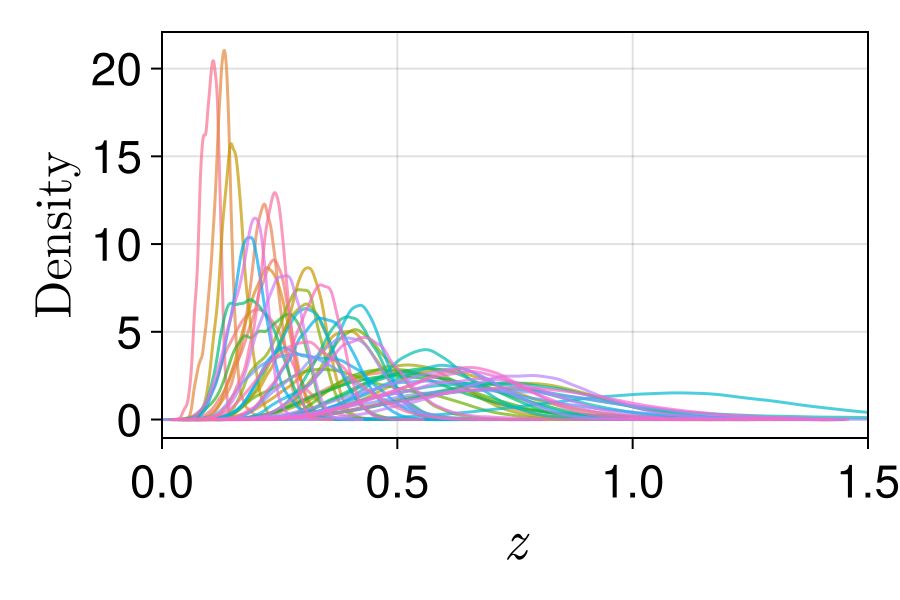

In [8]:
using KernelDensity

# Grouped data
pe_grouped = groups
cs = categorical_palette(length(pe_grouped))  # distinct colors

# Set up figure and axis
f = Figure(size=(450, 300))
a = Axis(f[1, 1],
    xlabel = L"z",
    ylabel = L"\mathrm{Density}",
    xlabelsize = 28,
    ylabelsize = 25,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    limits = (0, 1.5, nothing, nothing)  # x from 0 to 1.5, y auto
)

# Plot all PE redshift KDEs in distinct colors
for (i, evt) in enumerate(pe_grouped)
    z = evt.redshift
    if length(z) < 2
        continue
    end
    kde_result = kde(z)
    lines!(a, kde_result.x, kde_result.density, color = (cs[i], 0.7))
end

# Save the figure
if plot_save
    save(outdir * "z_kde.pdf", f, px_per_unit = 3)
end
f

# Population Plots

In [9]:
trace_samples_0p5 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains_0.5.nc"))
ne_min = dropdims(minimum(trace_samples_0p5.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p5.posterior.Neff_sel)
@info "p_cut = 0.5, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p5.posterior, :event)))"
trace = trace_samples_0p5

┌ Info: p_cut = 0.5, minimum Neff_samps: 4.25, minimum Neff_sel = 1801.0, 4*Nobs = 204
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sdnNjb2RlLXJlbW90ZQ==.jl:4


InferenceData with groups:
  > posterior
  > sample_stats

### Load GWTC3 Power Law + Peak Fit
Loaded from /mnt/home/sroy1/GWTC3/Rates/GWTC3_PLPP.h5

In [10]:
function load_GWTC3_population_data(filepath::String)
    h5open(filepath, "r") do file
        m1_GWTC3 = read(file["ms"])
        q_GWTC3 = read(file["qs"])
        z_GWTC3 = read(file["zs"])
        Rm1_med = read(file["Rm_med"])
        Rm1_5 = read(file["Rm_5"])
        Rm1_95 = read(file["Rm_95"])
        Rq_med = read(file["Rq_med"])
        Rq_5 = read(file["Rq_5"])
        Rq_95 = read(file["Rq_95"])
        Rz_med = read(file["Rz_med"])
        Rz_5 = read(file["Rz_5"])
        Rz_95 = read(file["Rz_95"])

        chieff_GWTC3 = read(file["chieffs"])
        Rchieff_med = read(file["Rchieff_med"])
        Rchieff_5 = read(file["Rchieff_5"])
        Rchieff_95 = read(file["Rchieff_95"])
        Rchieff_cdf_med = read(file["Rchieff_cdf_med"])
        Rchieff_cdf_5 = read(file["Rchieff_cdf_5"])
        Rchieff_cdf_95 = read(file["Rchieff_cdf_95"])


        return (; m1_GWTC3, q_GWTC3, z_GWTC3, Rm1_med, Rm1_5, Rm1_95, Rq_med, Rq_5, Rq_95, Rz_med, Rz_5, Rz_95, chieff_GWTC3, Rchieff_med, Rchieff_5, Rchieff_95, Rchieff_cdf_med, Rchieff_cdf_5, Rchieff_cdf_95)
    end
end

m1_GWTC3, q_GWTC3, z_GWTC3, Rm1_med, Rm1_5, Rm1_95, Rq_med, Rq_5, Rq_95, Rz_med, Rz_5, Rz_95, chieff_GWTC3, Rchieff_med, Rchieff_5, Rchieff_95, Rchieff_cdf_med, Rchieff_cdf_5, Rchieff_cdf_95 = load_GWTC3_population_data("../data/GWTC3_PLPP.h5")

(m1_GWTC3 = [2.0, 2.098098098098098, 2.196196196196196, 2.294294294294294, 2.3923923923923924, 2.4904904904904903, 2.5885885885885886, 2.6866866866866865, 2.784784784784785, 2.8828828828828827  …  99.11711711711712, 99.21521521521521, 99.31331331331332, 99.41141141141141, 99.5095095095095, 99.6076076076076, 99.7057057057057, 99.8038038038038, 99.9019019019019, 100.0], q_GWTC3 = [0.1, 0.10180360721442887, 0.10360721442885772, 0.10541082164328658, 0.10721442885771544, 0.10901803607214429, 0.11082164328657315, 0.11262525050100201, 0.11442885771543086, 0.11623246492985972  …  0.9837675350701403, 0.9855711422845691, 0.987374749498998, 0.9891783567134268, 0.9909819639278556, 0.9927855711422846, 0.9945891783567135, 0.9963927855711423, 0.9981963927855712, 1.0], z_GWTC3 = [0.0, 0.015151515151515152, 0.030303030303030304, 0.045454545454545456, 0.06060606060606061, 0.07575757575757576, 0.09090909090909091, 0.10606060606060606, 0.12121212121212122, 0.13636363636363635  …  1.3636363636363638, 1.378

## $m_1$ Marginal

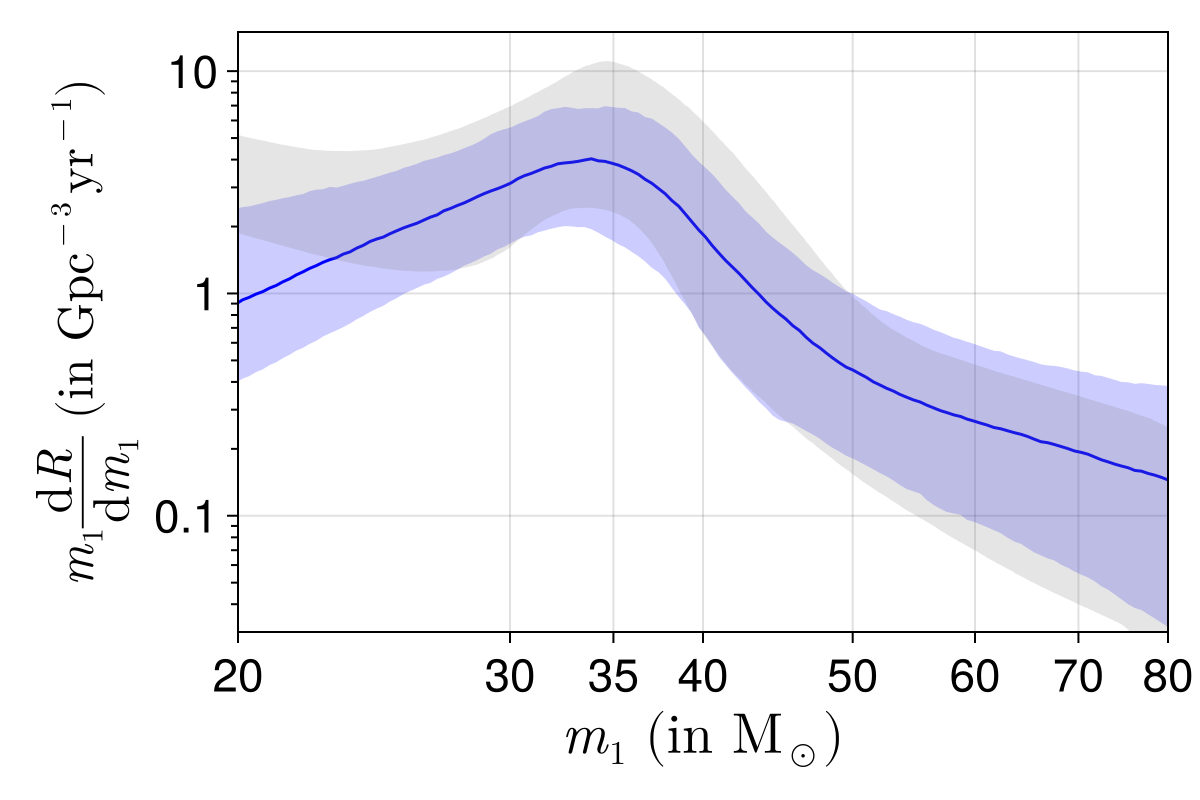

In [11]:
z_plot = 0.0
function marginal_m1_plot_paper(trace; limits=(20.0, 80.0, 0.03, 15.0), yticks=[0.01, 0.1, 1, 10, 100], yminorticks=[0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3,4,5,6,7,8,9,20], kwargs...)
    f = Figure(size=(600, 400))
    a = Axis(f[1,1],
    xlabel = L"m_1~(\mathrm{in~}\mathrm{M}_\odot)",
    ylabel = L"m_1 \frac{\mathrm{d} R}{\mathrm{d} m_1}~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
    xscale = log10, yscale = log10,
    xticks = [20, 30, 35, 40, 50, 60, 70, 80], xtickformat = "{:.0f}",
    yticks = ([0.01, 0.1, 1.0, 10.0, 100.0], ["0.01", "0.1", "1", "10", "100"]),
    yminorticks = yminorticks, yminorticksvisible = true,
    xlabelsize = 28,
    ylabelsize = 25,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    limits = limits)

    marginal_m1_plot_paper!(a, trace; kwargs...)

    # axislegend(a, position = :lb, labelsize = 21, framevisible = true)  # top-right inside the plot

    f
end


function marginal_m1_plot_paper!(a, trace; z_plot=z_plot, ms=exp.(log(m_bh_min):0.01:log(m_bh_max)), qs=0.001:0.01:1, draws=1000, rng=Random.default_rng(), color=Makie.wong_colors()[1], label="Median", savepath=savepath)
    p = trace.posterior
    dNdm1_matrix = zeros(length(ms), draws)

    @progress for i in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, 1:length(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdm1 = map(ms) do m
            integrand = map(qs) do q
                m2 = q * m
                if m2 < m_bh_min
                    zero(m)
                else
                    exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
                end
            end
            m * p.R[chain=c, draw=d] * trapz(qs, integrand)
        end

        dNdm1_matrix[:, i] = dNdm1
    end

    q5 = mapslices(x -> quantile(x, 0.05), dNdm1_matrix; dims=2)[:]
    q50 = mapslices(x -> quantile(x, 0.50), dNdm1_matrix; dims=2)[:]
    q95 = mapslices(x -> quantile(x, 0.95), dNdm1_matrix; dims=2)[:]

    band!(a, ms, q5, q95, color=(:blue, 0.2), label=L"\mathrm{This~Work}: 35\,\mathrm{M}_{\odot} \mathrm{Pop}")
    lines!(a, ms, q50, color=:blue) #, label=label

    band!(a, m1_GWTC3, Rm1_5, Rm1_95, color=(:grey, 0.2), label=L"\mathrm{Abbott+(2023b): All~BBHs}")
    
    # Save data if requested
    if savepath !== nothing
        h5open(savepath, "w") do file
            file["m1"] = ms
            file["R5_m1"] = q5
            file["R50_m1"] = q50
            file["R95_m1"] = q95
        end
    end
    
end

f = marginal_m1_plot_paper(trace)
if plot_save
    save(outdir * "m1_marginal_population.pdf", f, px_per_unit=3)
end
f

## Marginal $q$

In [12]:
q_golomb, Rq95_golomb, Rq5_golomb = h5open("../data/jacob_data.h5", "r") do file
    println("Contents of the file:")
    println(keys(file))

    q_tmp = read(file["q"])
    Rq95_tmp = read(file["Rq95"])
    Rq5_tmp = read(file["Rq5"])

    return q_tmp, Rq95_tmp,  Rq5_tmp
end

z_plot = 0.0
function marginal_q_plot_paper(trace; z_plot=z_plot, ms=exp.(log(m_bh_min):0.01:log(m_bh_max)), qs=collect(range(0.001, stop=1.0, length=100)), draws=draws, rng=Random.default_rng(), limits=(0.1, 1, 0.002, 100), yticks=[0.1, 1, 10, 100], yminorticks=[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90], color=Makie.wong_colors()[1], savepath=savepath)
    
    f = Figure(size=(600, 400))
    
    a = Axis(f[1,1],
        xlabel = L"q",
        ylabel = L"\frac{\mathrm{d} R}{\mathrm{d} q}~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
        yscale = log10,
        yticks = yticks,
        yminorticks = yminorticks,
        yminorticksvisible = true,
        ytickformat = "{:.1f}",
        xlabelsize = 28,
        ylabelsize = 25,
        xticklabelsize = xticklabelsize,
        yticklabelsize = yticklabelsize,
        limits = limits
    )

    p = trace.posterior
    dNdq_matrix = zeros(length(qs), draws)

    @progress for i in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, span(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdq = map(qs) do q
            integrand = map(ms) do m
                m2 = q * m
                if m2 < m_bh_min
                    zero(m)
                else
                    exp(log_dN(m, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
                end
            end
            p.R[chain=c, draw=d] * trapz(ms, integrand)
        end

        dNdq_matrix[:, i] = dNdq
    end

    # Compute quantiles
    q5 = mapslices(x -> quantile(x, 0.05), dNdq_matrix; dims=2)[:]
    q50 = mapslices(x -> quantile(x, 0.50), dNdq_matrix; dims=2)[:]
    q95 = mapslices(x -> quantile(x, 0.95), dNdq_matrix; dims=2)[:]

    band!(a, qs, q5, q95, color=(:blue, 0.2), label=L"\mathrm{This~Work}: 35\,\mathrm{M}_{\odot} \mathrm{Pop}")
    lines!(a, qs, q50, color=:blue)

    band!(a, q_GWTC3, Rq_5./Rq_med[end].*q50[end], Rq_95./Rq_med[end].*q50[end], color=(:grey, 0.2), label=L"\mathrm{Abbott+(2021): All~BBH}")
    norm = 23
    band!(a, q_golomb, Rq5_golomb .* q50[end] / norm, Rq95_golomb .* q50[end] / norm,
      color=(colorant"#57A988", 0.5),
      label=L"\mathrm{Golomb+(2023): All~BBH}")


    # Legend inside plot: This Work + Golomb
    axislegend(a,
    [PolyElement(color=(colorant"#57A988", 0.5))],
    [L"\mathrm{Golomb+(2023): All~BBH}"],
    position = :lt,
    labelsize = 21,
    framevisible = true
    )
    
    a.ylabelpadding[] = -10  # default is usually 10–15
    
    #text!(a, L"z=0", position = (0.22, 5), align = (:left, :bottom), fontsize = 21, color = :black)

    # Save data
    
    if savepath !== nothing
        h5open(savepath, "r+") do file
            file["q"] = qs
            file["R5_q"] = q5
            file["R50_q"] = q50
            file["R95_q"] = q95
        end
    end
    

    return f

end

Contents of the file:
["Rq5", "Rq95", "q"]


marginal_q_plot_paper (generic function with 1 method)

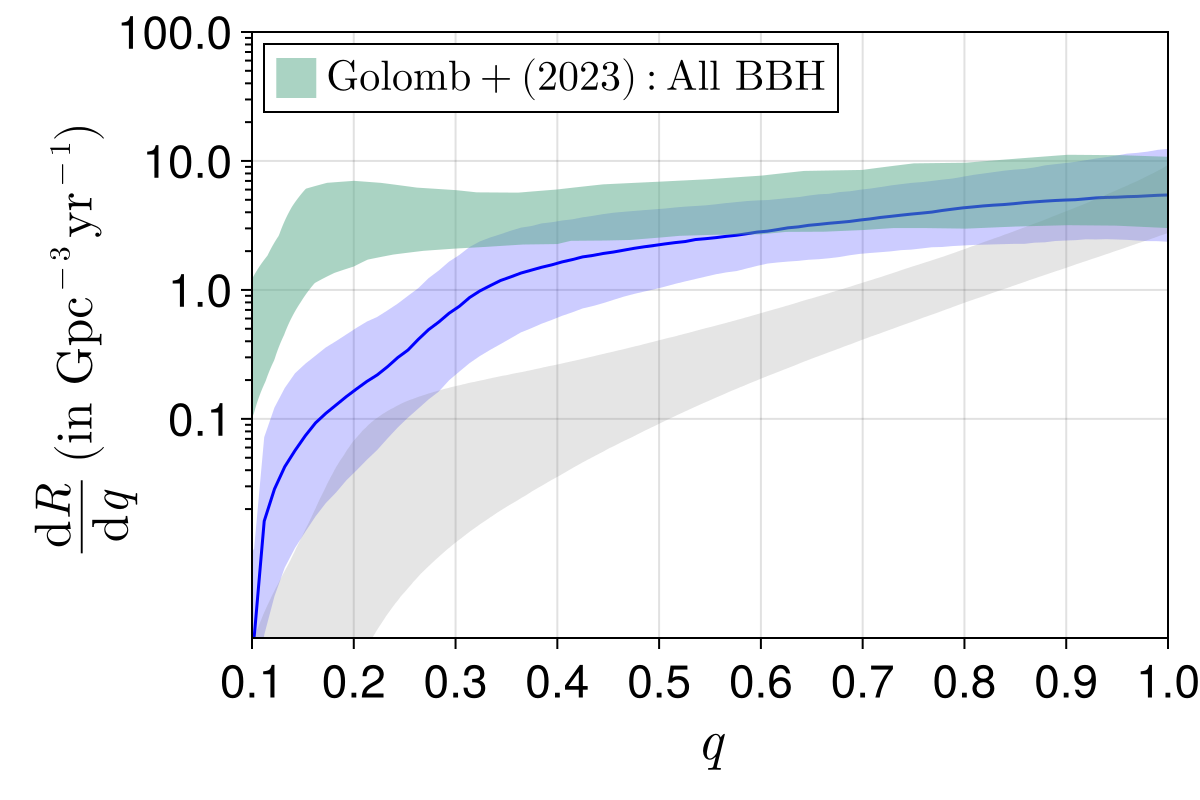

In [13]:

f = marginal_q_plot_paper(trace)
if plot_save
    save(outdir * "q_marginal_population.pdf", f, px_per_unit=3)
end
f


## Marginal $z$

In [14]:
function marginal_z_plot_paper(trace;
    ms = exp.(log(m_bh_min):0.01:log(m_bh_max)),
    qs = 0.001:0.01:1,
    zs = expm1.(range(log(1), stop=log(1 + 2), length=128)),
    draws = draws,
    rng = Random.default_rng(),
    limits = (0, 1.5, 10, 1000),
    yticks = [1, 10, 100, 1000],
    yminorticks = [2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90,200,300,400,500,600,700,800,900],
    plot_md_line = true,
    color = Makie.wong_colors()[1],
    savepath = savepath
)
    f = Figure(size=(600, 400))
    a = Axis(f[1, 1],
        xlabel = L"z",
        ylabel = L"R(z)~(\mathrm{in~}\mathrm{Gpc}^{-3}\mathrm{yr}^{-1})",
        yscale = log10,
        xlabelsize = 28,
        ylabelsize = 28,
        xticklabelsize = xticklabelsize,
        yticklabelsize = yticklabelsize,
        ytickformat = "{:.0f}",
        yticks = yticks,
        yminorticks = yminorticks,
        yminorticksvisible = true,
        xminorticksvisible = true,
        limits = limits
    )

    p = trace.posterior
    dNs = zeros(length(zs), draws)

    @progress for j in 1:draws
        c = rand(rng, span(dims(p, :chain)))
        d = rand(rng, span(dims(p, :draw)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        z1 = zs[1]
        dNdms = map(ms) do m
            integrand = map(qs) do q
                m2 = q * m
                if m2 < m_bh_min
                    zero(m)
                else
                    exp(log_dN(m, q, 0.0, z1, 0.0; ignore_chi_eff=true))
                end
            end
            trapz(qs, integrand)
        end

        norm = trace.posterior.R[draw=d, chain=c] *
               trapz(ms, dNdms) /
               exp(log_dN(m_plot, q_plot, 0.0, z1, 0.0; ignore_chi_eff=true))

        dNdz = map(zs) do z
            norm * exp(log_dN(m_plot, q_plot, 0.0, z, 0.0; ignore_chi_eff=true))
        end

        dNs[:, j] = dNdz
    end

    norm = 1.5
    PLP_band = band!(a, z_GWTC3, Rz_5 * norm, Rz_95 * norm, color=(:grey, 0.2))

    #imin = argmin(Rz_95 - Rz_5)
    vs = vec(var(log.(dNs), dims=2))
    imin = argmin(vs)
    @show imin
    norm = Rz_med[imin]

    medians = mapslices(median, dNs; dims=2)[:]
    lowers = mapslices(x -> quantile(x, 0.05), dNs; dims=2)[:]
    uppers = mapslices(x -> quantile(x, 0.95), dNs; dims=2)[:]

    band_plot = band!(a, zs, lowers .* norm ./ medians[imin], uppers .* norm ./ medians[imin], color=(:blue, 0.2))
    median_plot = lines!(a, zs, medians .* norm ./ medians[imin], color=:blue, linewidth=2)

    sfr_plot = nothing
    if plot_md_line
        mds = @. (1 + zs)^2.7 / (1 + ((1 + zs)/(1 + 1.9))^5.6)
        mds = mds .* norm ./ mds[imin]

        sfr_plot = lines!(a, zs, mds, color=:black, linestyle=:dash, linewidth=2, label=L"\mathrm{Star~Formation~Rate}")
    end

    axislegend(a, position = :lt, labelsize = 21, framevisible = true)
    
    # Save data if requested
    if savepath !== nothing
        h5open(savepath, "r+") do file
            file["z"] = zs
            file["R5_z"] = lowers .* norm ./ medians[imin]
            file["R50_z"] = medians .* norm ./ medians[imin]
            file["R95_z"] = uppers .* norm ./ medians[imin]
        end
    end
    
    return f
end


marginal_z_plot_paper (generic function with 1 method)

imin = 36


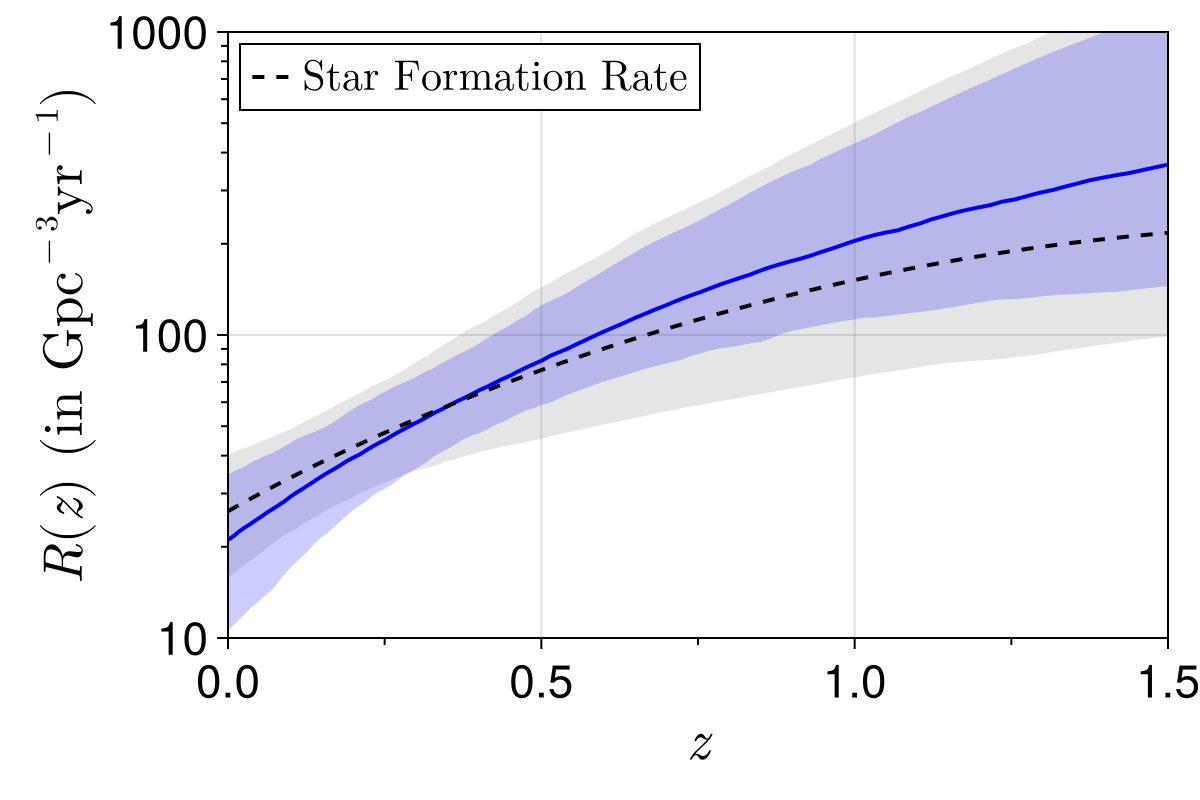

In [15]:
f = marginal_z_plot_paper(trace)
if plot_save
    save(outdir * "z_marginal_population.pdf", f, px_per_unit = 3)
end
f

## Marginal $\chi_{\mathrm{eff}}$

In [16]:
z_plot = 0.0
function chieff_pdf_plot_paper(
    trace;
    z_plot = z_plot,
    chi_effs = collect(-1.0:0.01:1.0),
    qs = collect(0.01:0.01:1.0),
    ms = exp.(range(log(m_bh_min), log(m_bh_max), length=100)),
    draws = draws,
    rng = Random.default_rng(),
    log_dN_from_chain_sample::Function
)
    dchi_eff = chi_effs[2] - chi_effs[1]

    p = trace.posterior
    dNdchi_samples = []

    for _ in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, span(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdchi = map(chi_effs) do chi_eff
            m_integrand = map(ms) do m
                q_integrand = map(qs) do q
                    m2 = q * m
                    if m2 < m_bh_min
                        0.0
                    else
                        exp(log_dN(m, q, chi_eff, z_plot, 0.0))
                    end
                end
                trapz(qs, q_integrand)
            end
            p.R[draw=d, chain=c] * trapz(ms, m_integrand)
        end

        dNdchi ./= trapz(chi_effs, dNdchi)  # normalize to make it a PDF
        push!(dNdchi_samples, dNdchi)
    end

    pdf_matrix = reduce(hcat, dNdchi_samples)
    pdf_median = mapslices(x -> quantile(x, 0.5), pdf_matrix; dims=2)[:]
    pdf_p5    = mapslices(x -> quantile(x, 0.05), pdf_matrix; dims=2)[:]
    pdf_p95    = mapslices(x -> quantile(x, 0.95), pdf_matrix; dims=2)[:]

    fig = Figure(size=(600, 400))
    ax = Axis(fig[1, 1],
        xlabel=L"\chi_\mathrm{eff}",
        ylabel=L"\frac{\mathrm{d} R}{\mathrm{d} \chi_{\mathrm{eff}}}~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
        xlabelsize=28, ylabelsize=25,
        xticklabelsize=xticklabelsize, yticklabelsize=yticklabelsize,
        xgridvisible=true, ygridvisible=true,
        limits=(-0.3, 0.4, 0.0, nothing)
    )

    band!(ax, chi_effs, pdf_p5, pdf_p95, color=(:blue, 0.2), label=L"\mathrm{This~Work}: 35\,\mathrm{M}_{\odot} \mathrm{Pop}")
    lines!(ax, chi_effs, pdf_median, color=:blue, linewidth=2)

    band!(ax, chieff_GWTC3, Rchieff_5, Rchieff_95, color=(:grey, 0.3), label=L"\mathrm{Abbott+(2021): All~BBH}")
    vlines!(ax, [0.0], color=:black, linestyle=:dash, linewidth=2)

    # Save to HDF5
    
    if savepath !== nothing
        h5open(savepath, "r+") do file
            file["chi_eff"] = collect(chi_effs)
            file["R5_chi_eff"] = pdf_p5
            file["R50_chi_eff"] = pdf_median
            file["R95_chi_eff"] = pdf_p95
        end
    end

    return fig

end


chieff_pdf_plot_paper (generic function with 1 method)

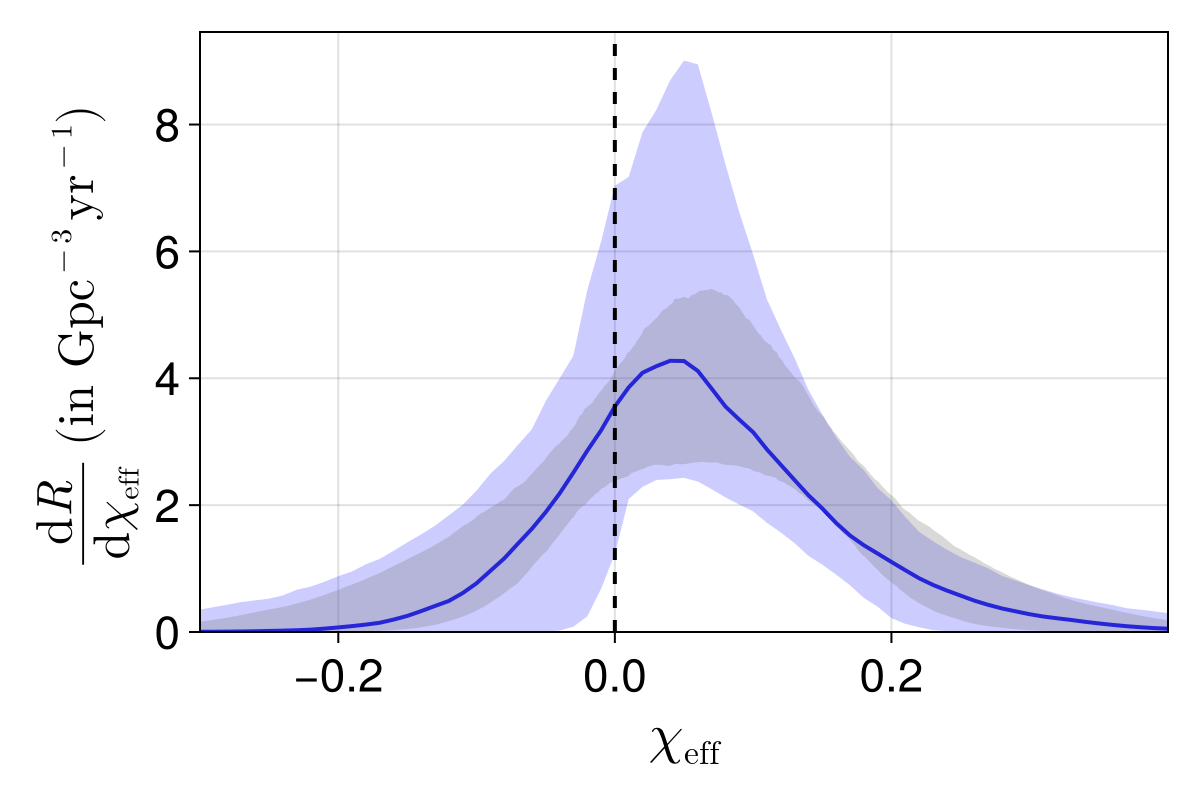

In [17]:
fig = chieff_pdf_plot_paper(
    trace;
    log_dN_from_chain_sample = log_dN_from_chain_sample
)
if plot_save
    save(outdir * "chieff_marginal_population.pdf", fig, px_per_unit = 3)
end
fig

## $q-\chi_{\mathrm{eff}}$ Population

In [18]:
z_plot = 0.0

function q_chieff_contour_plot_paper(trace;
    m_plot = m_plot,
    z_plot = z_plot,
    chi_effs = collect(-1.0:0.01:1.0),
    qs = collect(range(0.001, stop=1.0, length=100)),
    levels = range(0.1, stop=1.0, length=10),
    draws = draws,
    rng = Random.default_rng(),
    limits = (-0.3, 0.3, 0.5, 1.0),
    log_dN_from_chain_sample::Function
)
    f = Figure(size=(600, 600))
    ax = Axis(f[1, 1],
        xlabel = L"\chi_\mathrm{eff}",
        ylabel = L"q",
        xlabelsize = 30,
        ylabelsize = 30,
        xticklabelsize = xticklabelsize,
        yticklabelsize = yticklabelsize,
        xgridvisible = true,
        ygridvisible = true,
        limits = limits,
        xticks = vcat(-0.5:0.25:0.5, [-0.25, 0.25]) 
    )

    dchi_eff = chi_effs[2] - chi_effs[1]
    dq = qs[2] - qs[1]
    p = trace.posterior

    pqc_mean = [0.0 for ce in chi_effs, q in qs]
    N = length(dims(p, :chain)) * length(dims(p, :draw))
    i = 0

    @withprogress begin
        for c in span(dims(p, :chain))
            for d in span(dims(p, :draw))
                log_dN = log_dN_from_chain_sample(trace, d, c)

                pqc = [
                    if q * m_plot > m_bh_min
                        exp(log_dN(m_plot, q, ce, z_plot, 0.0))
                    else
                        0.0
                    end
                    for ce in chi_effs, q in qs
                ]

                pqc ./= sum(pqc) * dchi_eff * dq
                pqc_mean .+= pqc

                i += 1
                @logprogress i / N
            end
        end
        pqc_mean ./= N
    end

    # Normalize contour levels
    flat_vals = sort(vec(pqc_mean))
    cum_vals = cumsum(flat_vals) ./ sum(flat_vals)
    level_vals = [flat_vals[argmin(abs.(cum_vals .- l))] for l in levels]

    # Use a blue colormap with lower alpha
    blue_colormap = cgrad(:blues, alpha=0.7)

    contourf!(ax, chi_effs, qs, pqc_mean; levels=level_vals, colormap=blue_colormap)

    return f
end

q_chieff_contour_plot_paper (generic function with 1 method)

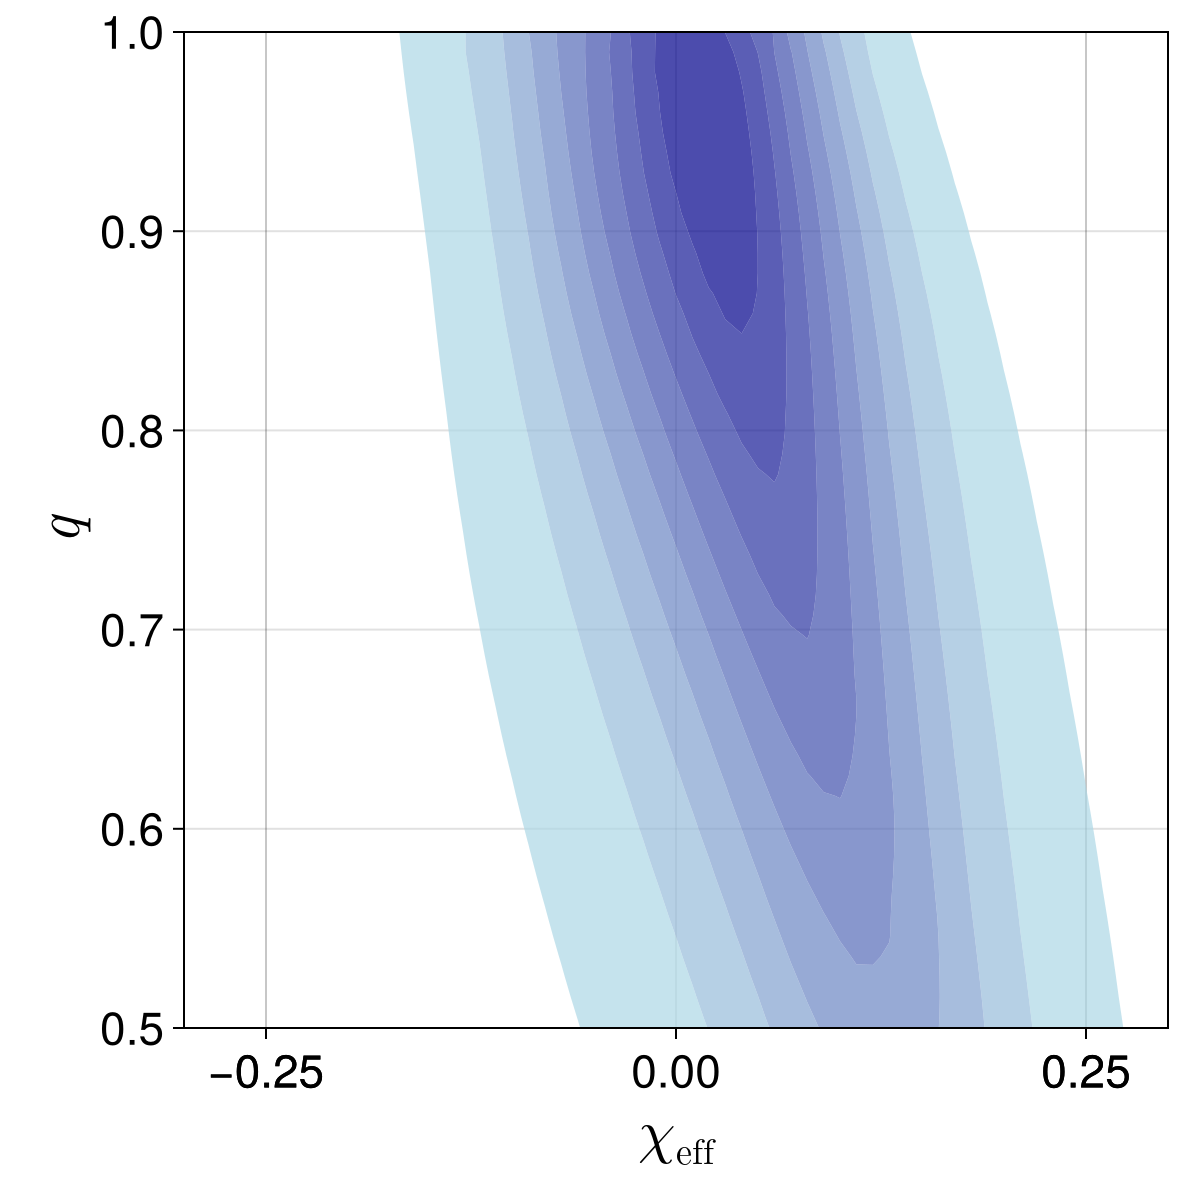

In [19]:
f = q_chieff_contour_plot_paper(trace; draws=draws, log_dN_from_chain_sample=log_dN_from_chain_sample)
if plot_save
    save(outdir * "q_chieff_population.pdf", f, px_per_unit = 3)
end
f

In [20]:
using JSON

datafile = "../data/posteriors_samples_spin_vs_q_FAR_1_in_1.json"

# Load and parse JSON
data = open(datafile, "r") do io
    JSON.parse(IOBuffer(read(io, String)))
end

# Extract arrays
mu0s_GWTC3 = collect(data["chiEff_mean"])
logsig0s_GWTC3 = collect(data["chiEff_logstd"])
alphas_GWTC3 = collect(data["chi_alpha"])
betas_GWTC3 = collect(data["chi_beta"])

# Now this works
println(alphas_GWTC3)

Any[-0.6187577990282505, -0.3665687554986094, -0.43170304172106994, -0.4458879425880223, -0.5552287649708043, -0.013224973453175526, -0.6236950307799525, -0.4114661436846288, -0.3585606522650463, -0.210298958475528, -0.3802541540519829, -0.3150716321539814, -0.4622877318193236, -0.3909422053008625, -0.1538761785773398, -0.3245207112326657, -0.4212053159183198, -0.34649758884098847, -0.4132643320511382, 0.025979902320315856, -0.4643290247567956, -0.31028750681582074, -0.34108996096540617, -0.2432736461892496, -0.03295931198510238, -0.250372861050553, -0.2317140814887447, -0.4038171182001511, -0.1296791469610811, -0.3838223315612324, -0.21979027967663003, -0.5529308450137498, -0.38253926267348554, -0.6441512443041341, -0.7994179337108419, -0.42257410321209227, -0.3193153771954787, -0.3526957289070395, -0.4454383024571585, -0.4931752664564624, -0.26753365507897264, -0.32903218274095136, 0.0074704822048332065, -0.14529358577828877, -0.4004436397989691, -0.3532935752294626, -0.2841151237939

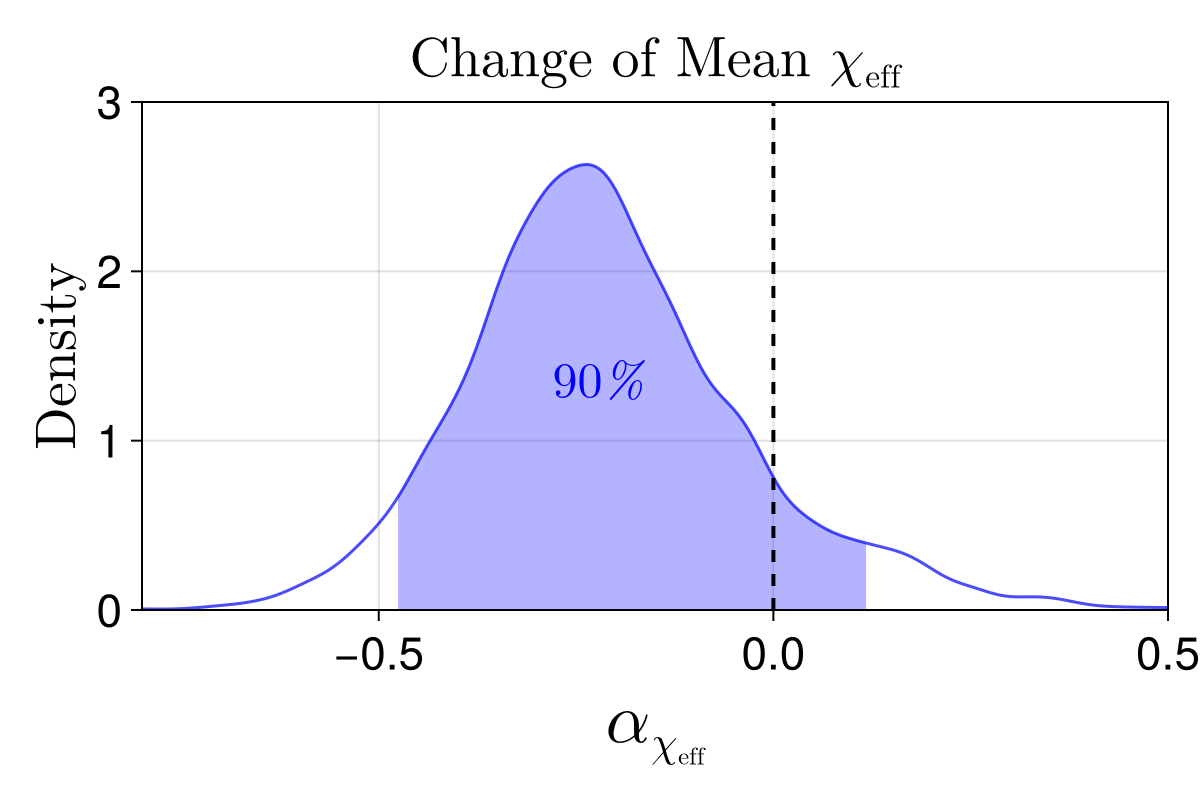

In [21]:
samples = vec(trace.posterior.alpha_chi_eff)

kde_result = kde(samples)
xs = kde_result.x
ys = kde_result.density

q05, q95 = quantile(samples, [0.05, 0.95])
mask_inside = (xs .>= q05) .& (xs .<= q95)

fig = Figure(size=(600, 400))
ax = Axis(fig[1, 1],
    xlabel=L"\alpha_{\chi_{\mathrm{eff}}}",
    ylabel=L"\mathrm{Density}",
    xlabelsize=35,
    ylabelsize=28,
    xticklabelsize=yticklabelsize,
    yticklabelsize=yticklabelsize,
    titlesize=28,
    title=L"\mathrm{Change~of~Mean}~\chi_{\mathrm{eff}}",
    limits=(-0.8, 0.5, 0, 3)
)

lines!(ax, xs, ys, color=(:blue, 0.7))

band!(ax, xs[mask_inside], zeros(sum(mask_inside)), ys[mask_inside], color=(:blue, 0.3))

vlines!(ax, [0.0], color=:black, linestyle=:dash, linewidth=2)
text!(ax, L"90%", position = (-0.28, 1.2), align = (:left, :bottom), fontsize = 25, color = :blue)

if plot_save
    save(outdir * "alpha_chieff.pdf", fig, px_per_unit=3)
end

fig


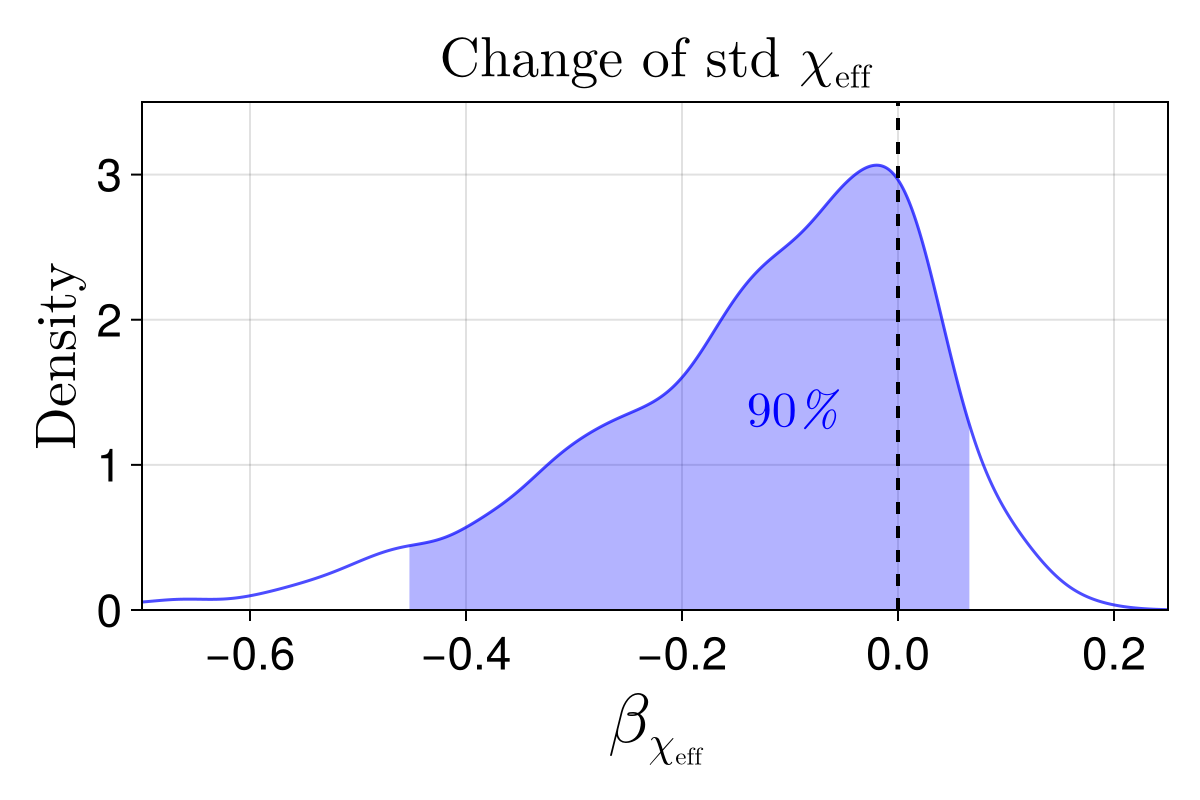

In [22]:
samples = vec(trace.posterior.beta_chi_eff)

kde_result = kde(samples)
xs = kde_result.x
ys = kde_result.density

q05, q95 = quantile(samples, [0.05, 0.95])
mask_inside = (xs .>= q05) .& (xs .<= q95)

fig = Figure(size=(600, 400))
ax = Axis(fig[1, 1],
    xlabel=L"\beta_{\chi_{\mathrm{eff}}}",
    ylabel=L"\mathrm{Density}",
    xlabelsize=35,
    ylabelsize=28,
    xticklabelsize=yticklabelsize,
    yticklabelsize=yticklabelsize,
    titlesize=28,
    title=L"\mathrm{Change~of~std}~\chi_{\mathrm{eff}}",
    limits = (-0.7, 0.25, 0, 3.5),
    yticks = [0, 1, 2, 3]
)

lines!(ax, xs, ys, color=(:blue, 0.7))

band!(ax, xs[mask_inside], zeros(sum(mask_inside)), ys[mask_inside], color=(:blue, 0.3))

vlines!(ax, [0.0], color=:black, linestyle=:dash, linewidth=2)
text!(ax, L"90%", position = (-0.14, 1.2), align = (:left, :bottom), fontsize = 25, color = :blue)

if plot_save
    save(outdir * "beta_chieff.pdf", fig, px_per_unit=3)
end

fig


## Print Median, 5% and 95% Values

In [23]:
function summarize_trace(trace)
    println("Parameter\tMedian\t5%\t95%")
    for (name, values) in pairs(trace.posterior)
        flat_values = vec(Array(values))  # Flatten all chains and draws into a 1D array
        median_val = median(flat_values)
        lower_val = quantile(flat_values, 0.05)
        upper_val = quantile(flat_values, 0.95)
        println("$(name)\t$(round(median_val, sigdigits=5))\t$(round(median_val-lower_val, sigdigits=5))\t$(round(upper_val-median_val, sigdigits=5))")
    end
end

summarize_trace (generic function with 1 method)

In [24]:
summarize_trace(trace)

Parameter	Median	5%	95%
alpha	-1.6132	2.1774	3.3866
m1_draw	35.593	11.496	32.697
mul	0.22742	0.29116	0.18578
Neff_samps	47.917	32.128	303.02
mtr	28.583	3.1684	5.3539
lambda	3.4013	1.1935	1.7598
m2s	28.505	16.483	10.874
qs	0.78873	0.40425	0.18778
kappa	5.4486	2.1792	2.3254
sigma	4.3945	2.9621	4.8113
sigmal	0.14097	0.13046	0.33903
alphahm	2.5859	2.1902	2.3052
R	5.1024	4.4972	12.951
m1s	35.088	11.902	30.914
chi_eff_draw	0.053248	0.1632	0.20907
rhm	0.10041	0.080857	0.28343
q_draw	0.77869	0.40343	0.20225
Neff_sel	6100.0	2251.5	3291.6
muh	0.00081134	0.079956	0.0624
beta	2.6085	3.6603	4.2268
mbhmax	33.903	4.1991	3.6672
beta_chi_eff	-0.10353	0.34927	0.16994
chi_effs	0.054115	0.14532	0.19322
sigmah	0.035789	0.03269	0.08356
zs	0.38603	0.25116	0.4944
log_rhm	-2.2985	1.6362	1.341
alpha_chi_eff	-0.22793	0.24807	0.34557
m2_draw	27.87	13.21	10.87
z_draw	0.40374	0.27378	0.47908
zp	2.4359	1.3007	1.4266


# Astrophysical Interpretation

## 2G-2G Merger
## $\mu$ and $\sigma$ of $\chi_{\mathrm{eff}}$ at $q=1$

### Expected Distribution of $\chi_{\mathrm{eff}}$ for 2G-2G BBH Merger:

$$
\chi_{\mathrm{eff}} = \frac{\chi_1\cos \theta_1 + q \chi_2\cos \theta_2}{1+q}
$$

The width:
$$
\Rightarrow \mathrm{var}(\chi_{\mathrm{eff}}) = \mathrm{var}\Bigg(\frac{\chi_1\cos \theta_1 + q \chi_2\cos \theta_2}{1+q}\Bigg)
$$

For 2G-2G merger, $q\approx 1, ~\chi_1 \approx 0.7,~\chi_2 \approx 0.7,~\mathrm{cov}(\chi_1\cos\theta_1, \chi_2\cos\theta_2) \approx 0$

$$
\Rightarrow \mathrm{std}(\chi_{\mathrm{eff}}) = \frac{1}{(1+q)}(\mathrm{var}(\chi_1\cos\theta_1) + q^2\mathrm{var}(\chi_2\cos\theta_2)+2q\mathrm{cov}(\chi_1\cos\theta_1, \chi_2\cos\theta_2))^{\frac{1}{2}} \approx \frac{0.7}{2}(\mathrm{var}(\cos\theta_1) + \mathrm{var}(\cos\theta_2))^{\frac{1}{2}}
$$

Now $\cos\theta_1 = U(-1,1)$ and $\cos\theta_2 = U(-1,1)$. So,

$$
\Rightarrow \mathrm{std}(\chi_{\mathrm{eff}}) \approx \frac{0.7}{2}\Bigg(\frac{4}{12}+\frac{4}{12}\Bigg)^{\frac{1}{2}} = \frac{0.7\sqrt{2}}{\sqrt{12}} = 0.28
$$

The mean:

$$
\mathrm{E}(\chi_{\mathrm{eff}}) = \mathrm{E}\Bigg(\frac{\chi_1\cos \theta_1 + q \chi_2\cos \theta_2}{1+q}\Bigg) \approx \frac{\mathrm{E}(\chi_1\cos\theta_1)+\mathrm{E}(\chi_2\cos\theta_2)}{2} = 0
$$

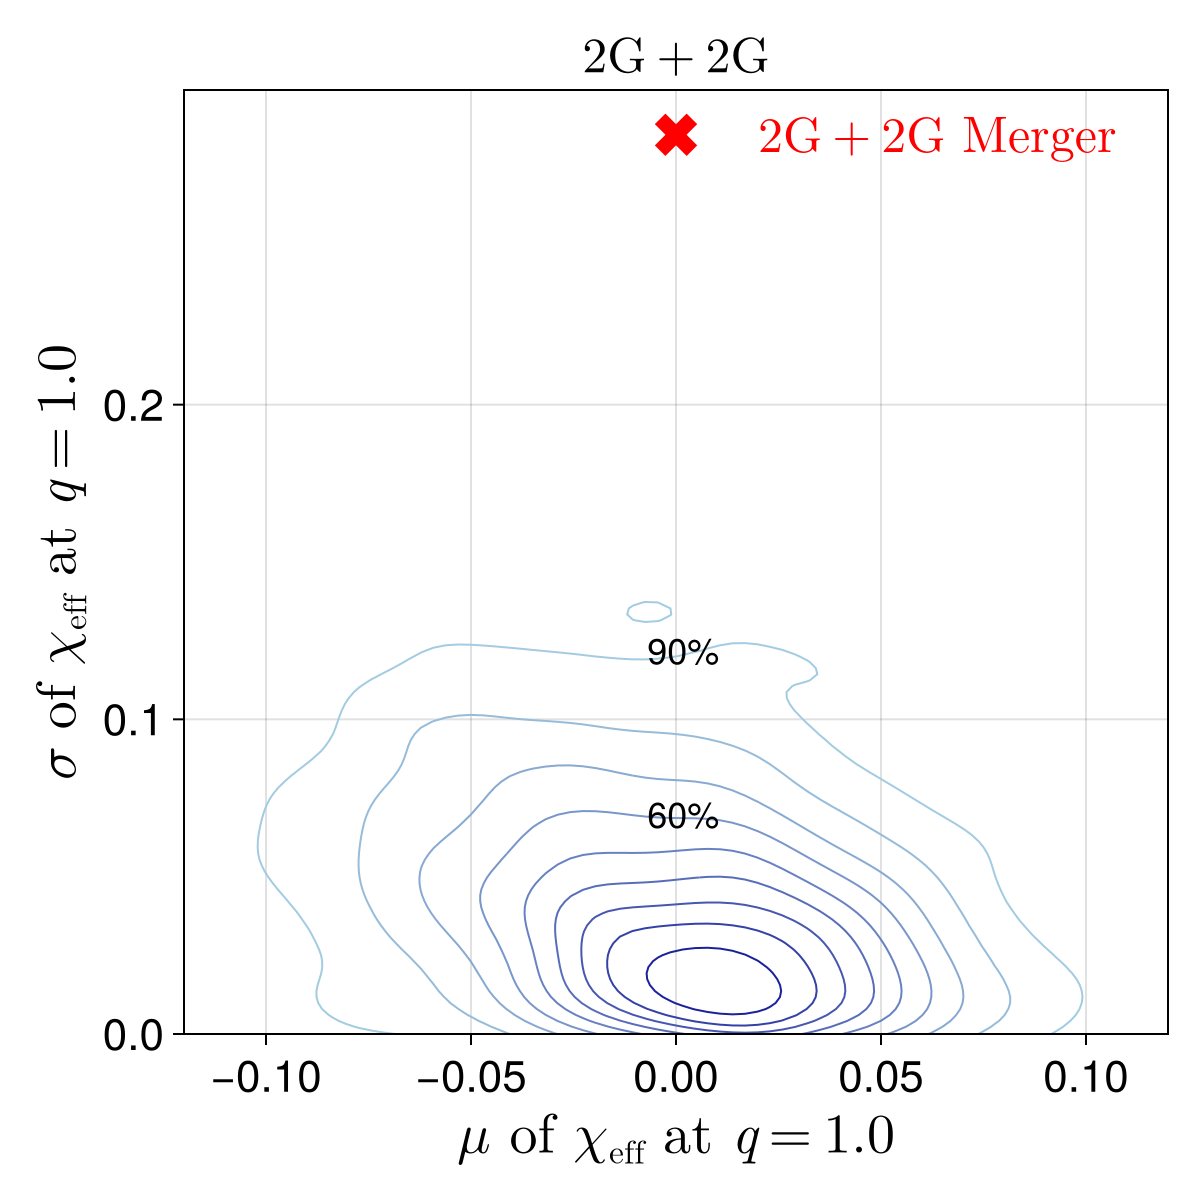

In [25]:
# 2g2g mu-sigma versus our fit
std_2g2g = 0.7*sqrt(2)/sqrt(12)

q_2g2g = 1.0  # For 2g2g mergers

# Evaluate posterior samples at q = 1
xvals = chieff_interp.(q_2g2g, vec(trace.posterior.mul), vec(trace.posterior.muh))
yvals = chieff_interp.(q_2g2g, vec(trace.posterior.sigmal), vec(trace.posterior.sigmah))

f = Figure(size=(600, 600))

ax = Axis(f[1, 1],
    xlabel = L"\mu~\mathrm{of}~\chi_\mathrm{eff}~\mathrm{at}~q=%$(q_2g2g)",
    ylabel = L"\sigma~\mathrm{of}~\chi_\mathrm{eff}~\mathrm{at}~q=%$(q_2g2g)",
    xlabelsize = 28,
    ylabelsize = 28,
    xticklabelsize = 22,
    yticklabelsize = 22,
    titlesize = 25,
    title = L"\mathrm{2G+2G}",
    limits = (-0.12, 0.12, 0, 0.3)
    )

kdecontour!(ax, xvals, yvals, levels = 0.1:0.1:0.9, colormap=:blues)

scatter!(ax, [0.0], [std_2g2g], color = :red, marker = :x, markersize = 30)

text!(ax, L"\mathrm{2G+2G~Merger}", position = (0.02, 0.277), align = (:left, :bottom), fontsize = 25, color = :red)
text!(ax, "90%", position = (-0.007, 0.115), align = (:left, :bottom), fontsize = 18, color = :black)
text!(ax, "60%", position = (-0.007, 0.063), align = (:left, :bottom), fontsize = 18, color = :black)

if plot_save
    save(outdir * "2G2G.pdf", f, px_per_unit = 3)
end
f

## 2G-1G Merger
## $\mu$ and $\sigma$ of $\chi_{\mathrm{eff}}$ at $q=0.5$

### Expected Distribution of $\chi_{\mathrm{eff}}$ for 2G-1G BBH Merger:

$$
\chi_{\mathrm{eff}} = \frac{\chi_1\cos \theta_1 + q \chi_2\cos \theta_2}{1+q}
$$

The width:
$$
\Rightarrow \mathrm{var}(\chi_{\mathrm{eff}}) = \mathrm{var}\Bigg(\frac{\chi_1\cos \theta_1 + q \chi_2\cos \theta_2}{1+q}\Bigg)
$$

We assume, $\mathrm{cov}(\chi_1\cos\theta_1, \chi_2\cos\theta_2) \approx 0$.

$$
\Rightarrow \mathrm{std}(\chi_{\mathrm{eff}}) \approx \frac{1}{(1+q)}(\mathrm{var}(\chi_1\cos\theta_1) + q^2\mathrm{var}(\chi_2\cos\theta_2))^{\frac{1}{2}}
$$

Massive BH is 2G: $\chi_1 = 0.7,~q=0.5$.

$$
\Rightarrow \mathrm{std}(\chi_{\mathrm{eff}}) \approx \frac{1}{(1+0.5)}(0.7^2\mathrm{var}(\cos\theta_1) + 0.5^2\mathrm{var}(\chi_2\cos\theta_2))^{\frac{1}{2}} \geq \frac{0.7}{1.5}(\mathrm{var}(\cos\theta_1))^{\frac{1}{2}}
$$

The equality holds for $\chi_2=0$.

Now $\cos\theta_1 = U(-1,1)$. So,

$$
\Rightarrow \mathrm{std}(\chi_{\mathrm{eff}}) \geq \frac{0.7}{1.5}\Bigg(\frac{4}{12}\Bigg)^{\frac{1}{2}} = 0.27
$$

The mean:

$$
\mathrm{E}(\chi_{\mathrm{eff}}) = \mathrm{E}\Bigg(\frac{\chi_1\cos \theta_1 + q \chi_2\cos \theta_2}{1+q}\Bigg) \approx \frac{0.7\mathrm{E}(\cos\theta_1)+\mathrm{E}(\chi_2\cos\theta_2)}{1.5}
$$

Unlike variance, there is no lower bound of mean. If $\chi_2=0$:

$$
\mathrm{E}(\chi_{\mathrm{eff}}) = 0
$$

In [ ]:
# Parameters for the 2G–1G merger
std_2g1g = 0.7/1.5*(2/sqrt(12))
q_2g1g = 0.5

# Evaluate posterior samples at q = 0.5
xvals = chieff_interp.(q_2g1g, vec(trace.posterior.mul), vec(trace.posterior.muh))
yvals = chieff_interp.(q_2g1g, vec(trace.posterior.sigmal), vec(trace.posterior.sigmah))

f = Figure(size = (600, 600))

ax = Axis(f[1, 1],
xlabel = L"\mu~\mathrm{of}~\chi_\mathrm{eff}~\mathrm{at}~q=%$(q_2g1g)",
ylabel = L"\sigma~\mathrm{of}~\chi_\mathrm{eff}~\mathrm{at}~q=%$(q_2g1g)",
    xlabelsize = 28,
    ylabelsize = 28,
    xticklabelsize = 22,
    yticklabelsize = 22,
    titlesize = 25,
    title = L"\mathrm{2G+1G}",
    limits = (-0.12, 0.23, 0, 0.45)
)

band!(ax,
    [-0.12, 0.23],
    [std_2g1g, std_2g1g],
    [ylims_manual[2], ylims_manual[2]],
    color = (:grey90, 1),
    label = L"\mathrm{2G-1G~Merger~with~any}~\chi_2"
)

kdecontour!(ax, xvals, yvals, levels = 0.1:0.1:0.9, colormap = :blues)

scatter!(ax, [0.0], [std_2g1g], color = :red, marker = :x, markersize = 30)

text!(ax, L"\mathrm{2G+1G~Merger~with}~\chi_2=0", position = (-0.05, 0.28), align = (:left, :bottom), fontsize = 25, color = :red)
text!(ax, L"\mathrm{2G+1G~Merger~with~any}~\chi_2", position = (-0.05, 0.4), align = (:left, :bottom), fontsize = 25, color = :grey30)
text!(ax, "90%", position = (0.08, 0.23), align = (:left, :bottom), fontsize = 18, color = :black)
text!(ax, "60%", position = (0.08, 0.15), align = (:left, :bottom), fontsize = 18, color = :black)

if plot_save
    save(outdir * "2G1G.pdf", f, px_per_unit = 3)
end
f


UndefVarError: UndefVarError: `xlims` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [27]:
println(0.7*sqrt(2)/sqrt(12))
println(0.7/1.5*(2/sqrt(12)))

0.28577380332470415
0.2694301256218254


#### Check How Well Can We Model Uniform by a Normal Distribution (For 2G-1G BH):

In [28]:
Random.seed!(42)

true_dist = Uniform(-0.27 * sqrt(3), 0.27 * sqrt(3))
samples = rand(true_dist, 1000000)

fitted_dist = fit(Normal, samples)

println("Fitted Normal Distribution:")
println("mean  = ", round(mean(fitted_dist), digits=10))
println("std   = ", round(std(fitted_dist), digits=10))

Fitted Normal Distribution:
mean  = -0.000439746
std   = 0.2700742457


#### They are same!